In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text, num_show=1):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    if i == num_show:
      break
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/new/temp/textsum/model.seq2seq.copy'
predictor = melt.Predictor(model_dir)

def inference(text, num_show=1):
  predict(predictor, text, num_show=num_show)

ENCODE_UNK 1
restore from /home/gezi/new/temp/textsum/model.seq2seq.copy/model.ckpt-9.0-759000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/textsum/model.seq2seq.copy/model.ckpt-9.0-759000


import graph ok /home/gezi/new/temp/textsum/model.seq2seq.copy/model.ckpt-9.0-759000.meta
restore ok /home/gezi/new/temp/textsum/model.seq2seq.copy/model.ckpt-9.0-759000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5143, 5088, 7316, 532, 13, 691, 742, 805, 5143, 5088, 7316, 532, 13, 11810, 16506, 0, 0, 0, 0, 0] len: 20
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
0 [5143, 5088, 1] 大棚/辣椒/<EOS> 0.256004801166 -1.36256 -1.36256 [-0.039493673, -0.2008398, -1.1222256]


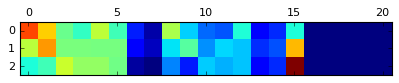

beam search using time(ms): 906.137943268
word_ids [214, 899, 322, 1866, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球/吗
你/去/打/篮球/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.039679310506 -3.22693 -3.22693 [-0.835428, -0.057762988, -2.3337343]


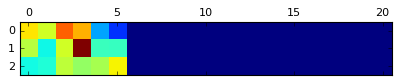

beam search using time(ms): 200.761079788
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0310325176026 -3.47272 -3.47272 [-1.0979261, -0.031409319, -2.3433843]


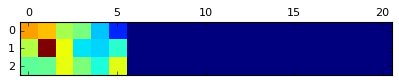

beam search using time(ms): 195.462942123
word_ids [1492, 210, 267, 244, 655, 8, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [267, 244, 655, 1] 周/华/健/<EOS> 0.129544975173 -2.04373 -2.04373 [-0.67259514, -0.063242339, -0.019372895, -1.2885168]


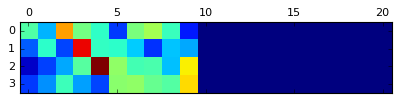

beam search using time(ms): 202.566862106
word_ids [25394, 84, 2743, 19, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [19, 807, 752, 1] 高/晓/松/<EOS> 0.14520659821 -1.9296 -1.9296 [-1.350368, -0.034582667, -0.016368283, -0.52827883]


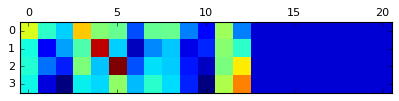

beam search using time(ms): 228.482961655
word_ids [60, 811, 2742, 235, 949, 3383, 60, 811, 2742, 2841, 1679, 57, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
0 [60, 811, 2742, 1] 王/凯/整容/<EOS> 0.124407774199 -2.08419 -2.08419 [-0.056945093, -0.050137069, -0.31893289, -1.6581755]


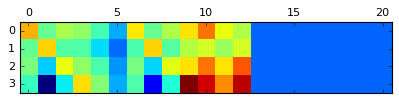

beam search using time(ms): 214.434146881
word_ids [6423, 1083, 5327, 226, 24332, 668, 668, 163, 13, 4073, 62, 107, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
0 [163, 62, 107, 1] 性感/黑/丝/<EOS> 0.0172134344991 -4.06207 -4.06207 [-1.4203824, -1.4154924, -0.026232982, -1.1999575]


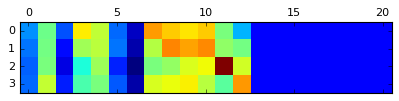

beam search using time(ms): 207.072973251
word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0783895341385 -2.54606 -2.54606 [-0.9508636, -0.24795051, -1.3472507]


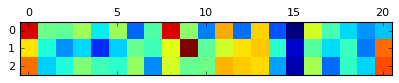

beam search using time(ms): 191.114902496
word_ids [37, 14356, 7, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 14356, 1] 美女/劈叉/<EOS> 0.0724620054775 -2.62469 -2.62469 [-1.4583986, -0.76078528, -0.40550905]


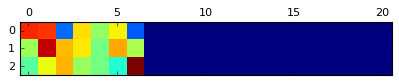

beam search using time(ms): 191.316843033
word_ids [1817, 7, 1252, 228, 7, 4006, 228, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
》/ /卫生/间/ /洗手/间/ 
》/ /卫生/间/ /洗手/间/ 
0 [1252, 228, 4006, 228, 1] 卫生/间/洗手/间/<EOS> 0.0422139018739 -3.16501 -3.16501 [-0.9804306, -7.1525551e-07, -0.99721122, -6.5443761e-05, -1.1872978]


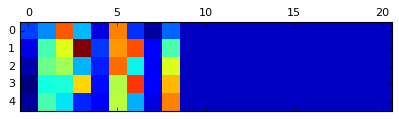

beam search using time(ms): 217.44799614
word_ids [2234, 7, 3885, 4193, 828, 146, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
iphone/ /6s/耐克/主题/手机/壁纸
iphone/ /6s/耐克/主题/手机/壁纸
0 [4193, 146, 30, 1] 耐克/手机/壁纸/<EOS> 0.025832011398 -3.65614 -3.65614 [-1.4963666, -1.1249862, -0.39061281, -0.64417529]


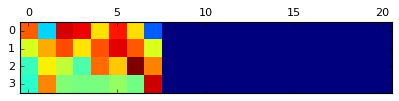

beam search using time(ms): 199.796915054


In [8]:
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
predict(predictor, '你去打篮球吗')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('年少不懂高晓松,读懂已不再少年')
inference('王凯整容了吗_王凯整容前后对比照片')
inference('【贴图】韩敏英--性感小吊带黑丝')
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看')
inference('美女劈叉 鼻血狂喷')
inference('》 卫生间 洗手间 ')
inference('iphone 6s耐克主题手机壁纸')

word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
0 [1298, 426, 8246, 9974, 448, 1] 赵丽/颖/蜀山/战纪/剧照/<EOS> 0.0214548970573 -3.8418 -3.8418 [-0.91048646, -0.0033951518, -1.4176042, -0.28959027, -1.0548966, -0.16582975]


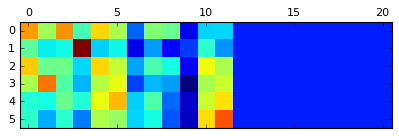

beam search using time(ms): 250.254869461


In [9]:
inference('蜀山战纪赵丽颖古装剧照(12张) ')

word_ids [323, 56, 758, 45, 301, 9147, 1733, 410, 570, 1100, 8, 6091, 1817, 0, 0, 0, 0, 0, 0, 0] len: 20
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
0 [6091, 45, 301, 1] 小鱼/简/笔画/<EOS> 0.0254208296856 -3.67219 -3.67219 [-2.243325, -0.59383792, -0.046348233, -0.78867507]


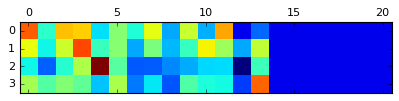

beam search using time(ms): 206.129074097


In [10]:
inference('幼儿园动物简笔画教案《两条漂亮的小鱼》')

word_ids [334, 595, 85, 1034, 11, 5593, 121, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
第/六/感/美甲/美/睫/纹/秀
第/六/感/美甲/美/睫/纹/秀
0 [11, 5593, 1034, 1] 美/睫/美甲/<EOS> 0.0167797881359 -4.08758 -4.08758 [-1.240347, -0.033119909, -2.0739636, -0.74014962]


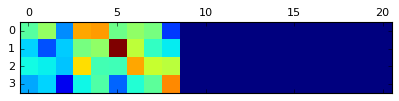

beam search using time(ms): 205.720901489


In [11]:
inference('第六感美甲美睫纹秀')

word_ids [4305, 5762, 3136, 5697, 2060, 389, 1961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
2013/春夏/男装/米兰/时装/秀/9
2013/春夏/男装/米兰/时装/秀/9
0 [2060, 389, 1] 时装/秀/<EOS> 0.0467839608641 -3.06221 -3.06221 [-1.782649, -0.26101643, -1.0185493]


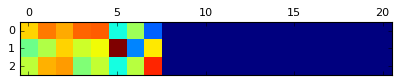

beam search using time(ms): 202.124834061


In [12]:
inference('2013春夏男装米兰时装秀9')

word_ids [772, 7630, 67, 89652, 8, 19841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
关于/房价/最/透彻/的/解读
关于/房价/最/透彻/的/解读
0 [7630, 1] 房价/<EOS> 0.0304600162269 -3.49134 -3.49134 [-1.2588472, -2.2324932]


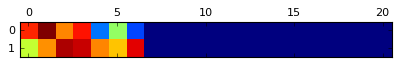

beam search using time(ms): 194.236040115


In [13]:
inference('关于房价最透彻的解读')

word_ids [4667, 630, 7902, 51, 1297, 10515, 4961, 7170, 16504, 3467, 25032, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
0 [10515, 4961, 1] 职称/制度/<EOS> 0.0203152919565 -3.89638 -3.89638 [-1.6232252, -1.1276441, -1.1455122]


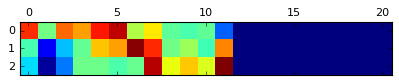

beam search using time(ms): 218.457937241


In [14]:
inference('辽宁省中小学教师职称制度改革实施方案出台')

word_ids [4470, 452, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
骷髅/情侣/纹身
骷髅/情侣/纹身
0 [452, 208, 1] 情侣/纹身/<EOS> 0.0144043940407 -4.24022 -4.24022 [-1.2628467, -0.88362956, -2.0937459]


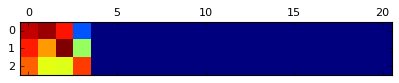

beam search using time(ms): 198.6079216


In [15]:
inference('骷髅情侣纹身')

word_ids [42999, 869, 1474, 363, 8, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.0287784451344 -3.54813 -3.54813 [-1.7611768, -0.095403291, -1.047179, -0.64436948]


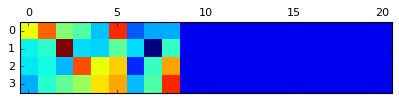

酷似/朴/姬/兰/的/刘/亦/菲
1 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0234192347244 -3.7542 -3.7542 [-0.78555268, -0.0086165313, -0.00046456989, -2.9595637]


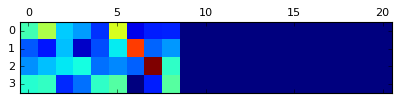

beam search using time(ms): 294.156074524


In [16]:
inference('酷似朴姬兰的刘亦菲', 2)

word_ids [42999, 164, 926, 649, 8, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.0350219783783 -3.35178 -3.35178 [-1.9564016, -0.20547083, -0.63746202, -0.55244482]


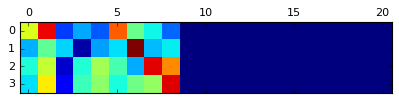

酷似/刘/亦/菲/的/朴/姬/兰
1 [164, 926, 649, 1] 刘/亦/菲/<EOS> 0.0191955491976 -3.95308 -3.95308 [-0.73751521, -0.0062900432, -0.00016497205, -3.2091067]


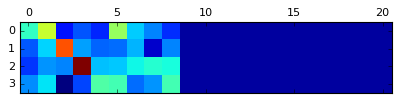

酷似/刘/亦/菲/的/朴/姬/兰
2 [869, 1474, 1] 朴/姬/<EOS> 0.00879210583887 -4.7339 -4.7339 [-1.9564016, -0.20547083, -2.5720286]


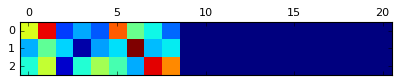

酷似/刘/亦/菲/的/朴/姬/兰
3 [164, 926, 649, 869, 1474, 363, 1] 刘/亦/菲/朴/姬/兰/<EOS> 0.00474793863207 -5.35004 -5.35004 [-0.73751521, -0.0062900432, -0.00016497205, -3.2370007, -0.34629866, -0.66499776, -0.35777777]


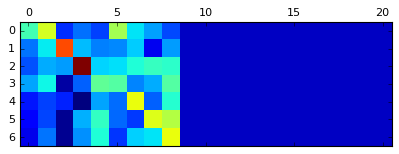

酷似/刘/亦/菲/的/朴/姬/兰
4 [42999, 164, 926, 649, 1] 酷似/刘/亦/菲/<EOS> 0.00261977744673 -5.94467 -5.94467 [-4.4956179, -0.32718977, -0.0096527264, -0.00011181206, -1.1120939]


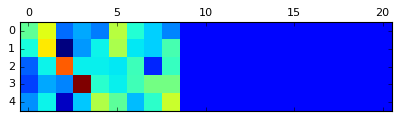

beam search using time(ms): 568.238019943


In [17]:
inference('酷似刘亦菲的朴姬兰', 5)

word_ids [97, 80, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
我/爱/打/篮球
我/爱/打/篮球
0 [322, 1866, 1] 打/篮球/<EOS> 0.0449704934715 -3.10175 -3.10175 [-0.60929525, -0.14179687, -2.3506565]


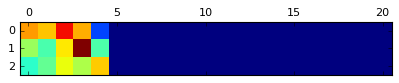

beam search using time(ms): 241.599082947


In [18]:
inference('我爱打篮球')

word_ids [322, 1866, 181, 84, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/好/不/好
打/篮球/好/不/好
0 [322, 1866, 1] 打/篮球/<EOS> 0.0317366671634 -3.45028 -3.45028 [-0.86134088, -0.033457294, -2.5554843]


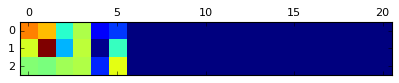

beam search using time(ms): 201.9739151


In [19]:
inference('打篮球好不好')

word_ids [27135, 7, 1614, 6577, 8, 157, 10898, 21077, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
0 [27135, 1] 厄瓜多尔/<EOS> 0.0751061104589 -2.58885 -2.58885 [-0.92967373, -1.6591797]


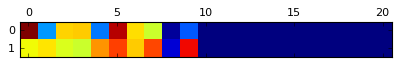

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
1 [157, 10898, 21077, 1] 南/美洲/国度/<EOS> 0.0479303299167 -3.03801 -3.03801 [-1.5034566, -0.012379945, -0.80093616, -0.72123408]


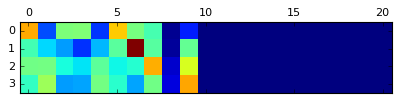

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
2 [27135, 21077, 1] 厄瓜多尔/国度/<EOS> 0.0252347686281 -3.67953 -3.67953 [-0.92967373, -2.4559975, -0.2938613]


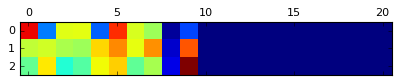

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
3 [157, 10898, 1] 南/美洲/<EOS> 0.0156745725003 -4.15572 -4.15572 [-1.5034566, -0.012379945, -2.6398787]


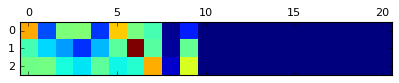

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
4 [27135, 157, 10898, 1] 厄瓜多尔/南/美洲/<EOS> 0.0102106510486 -4.58432 -4.58432 [-0.92967373, -2.3576651, -0.028134078, -1.268851]


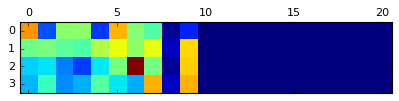

beam search using time(ms): 529.349088669


In [20]:
inference('厄瓜多尔 美丽神秘的南美洲国度 ', 5)

word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.078389515449 -2.54607 -2.54607 [-0.95086396, -0.2479506, -1.3472506]


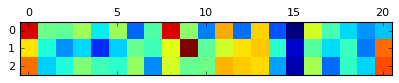

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
1 [1672, 485, 3243, 1] 彭/于/晏/<EOS> 0.0415747177671 -3.18026 -3.18026 [-0.96298993, -0.0054328414, -0.0012875847, -2.2105527]


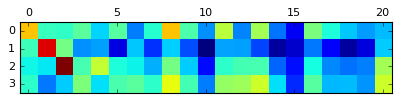

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
2 [16400, 670, 1672, 485, 3243, 1] 寒战/2/彭/于/晏/<EOS> 0.0291259803881 -3.53612 -3.53612 [-0.95086396, -0.2479506, -1.8752409, -0.013909428, -0.0013738965, -0.44678593]


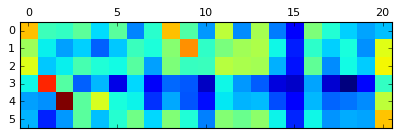

beam search using time(ms): 354.638814926


In [21]:
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看', 3)